Imports and load models

In [16]:
#pip install transformers[sentencepiece]

import sklearn
from sklearn.datasets import load_files
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import zipfile
import spacy
import re
import torch
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

# Load Aspect-Based Sentiment Analysis model
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification \
  .from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# Load a traditional Sentiment Analysis model
sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_model = pipeline("sentiment-analysis", model=sentiment_model_path,
                          tokenizer=sentiment_model_path)

c:\Users\david\Documents\GitHub\TNM108\Project\venv\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Example for how the code works


In [18]:
sentence = "We had a great experience at the restaurant, food was delicious, but " \
  "the service was kinda bad"
print(f"Sentence: {sentence}")
print()

aspect = "food"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

# ABSA of "service"
aspect = "service"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()
# Sentiment of aspect 'service' is:
# Label negative: 0.9946129322052002
# Label neutral: 0.002369985682889819
# Label positive: 0.003017079783603549

# Overall sentiment of the sentence
sentiment = sentiment_model([sentence])[0]
print(f"Overall sentiment: {sentiment['label']} with score {sentiment['score']}")
# Overall sentiment: Negative with score 0.7706006765365601

Sentence: We had a great experience at the restaurant, food was delicious, but the service was kinda bad

Sentiment of aspect 'food' is:
Label negative: 0.000998911913484335
Label neutral: 0.0018238150514662266
Label positive: 0.997177243232727

Sentiment of aspect 'service' is:
Label negative: 0.9946129322052002
Label neutral: 0.0023699868470430374
Label positive: 0.003017081180587411

Overall sentiment: negative with score 0.7706007361412048


Function for analysing sentiment of different aspects 

In [19]:
# def analyze_aspects_sentiment(sentence, aspects, absa_tokenizer, absa_model):
#     for aspect in aspects:
#         # Tokenize the input
#         inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
        
#         # Get the model outputs
#         outputs = absa_model(**inputs)
        
#         # Apply softmax to obtain probabilities
#         probs = F.softmax(outputs.logits, dim=1)
#         probs = probs.detach().numpy()[0]  # Convert tensor to numpy array
        
#         # Print the sentiment probabilities
#         print(f"Sentiment of aspect '{aspect}' is:")
#         for prob, label in zip(probs, ["negative", "neutral", "positive"]):
#             print(f"  {label.capitalize()}: {prob:.4f}")
#         print()  # Add a newline for better readability
import torch.nn.functional as F

def analyze_aspects_sentiment(sentence, aspects, absa_tokenizer, absa_model, sentiment_model):
    sentiment_results = {}

    # Analyze sentiment for each aspect (e.g., food, service)
    for aspect in aspects:
        if aspect.lower() not in sentence.lower():
            print(f"Aspect '{aspect}' not found in the sentence.")
            continue  # Skip sentiment analysis for this aspect
        inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
        outputs = absa_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        probs = probs.detach().numpy()[0]
        
        # Format aspect sentiment result
        sentiment_results[aspect] = {
            "negative": probs[0],
            "neutral": probs[1],
            "positive": probs[2]
        }

        # Print the sentiment of the aspect in the requested format
        print(f"Sentiment of aspect '{aspect}' is:")
        for label, prob in sentiment_results[aspect].items():
            print(f"Label {label}: {prob}")
        print()

    # Overall sentiment of the sentence
    sentiment = sentiment_model([sentence])[0]
    print(f"Overall sentiment: {sentiment['label']} with score {sentiment['score']}")

    return sentiment_results

Load dataset

In [20]:
# Load the CSV file
file_path = 'election_day_tweets_data/election_day_tweets.csv' 
elections_2016 = pd.read_csv(file_path)

elections_2016.sort_values(by='created_at').info()

<class 'pandas.core.frame.DataFrame'>
Index: 397629 entries, 162840 to 92778
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   text                           397629 non-null  object 
 1   created_at                     397629 non-null  object 
 2   geo                            2564 non-null    object 
 3   lang                           397629 non-null  object 
 4   place                          30832 non-null   object 
 5   coordinates                    2564 non-null    object 
 6   user.favourites_count          397629 non-null  int64  
 7   user.statuses_count            397629 non-null  int64  
 8   user.description               353403 non-null  object 
 9   user.location                  302677 non-null  object 
 10  user.id                        397629 non-null  int64  
 11  user.created_at                397629 non-null  object 
 12  user.verified                  

Preprocess tweets

In [21]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        #t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = re.sub(r"#", "", t)
        t = re.sub(r"#", "", t)  # Remove only the '#' symbol
        #t = 'http' if t.startswith('http') else t
        #remove links (URLs)
        t = re.sub(r'http\S+|www\S+|https\S+', '', t)
        new_text.append(t)
        t = t.lower().strip()

    return " ".join(new_text)

Test on some tweets:

In [22]:
# Set pandas display options to show the full content of cells
pd.set_option('display.max_colwidth', None)  # Show full text in columns
pd.set_option('display.max_rows', None)  # Optional: Show all rows if needed

elections_2016['text'] = elections_2016['text'].str.lower()  # Convert to lowercase
print(elections_2016['text'].head())
# Apply the cleaning function to the 'text' column
elections_2016['cleaned_text'] = elections_2016['text'].apply(preprocess)
print(elections_2016[['cleaned_text']].head())
# Define specific words to search for
specific_words = ['hillary', 'clinton']
our_specific_words = ['hillary', 'clinton', 'trump']

# Combine the words into a single regular expression pattern
pattern = '|'.join(rf'\b{word}\b' for word in specific_words)  # Matches whole words only
pattern2 = '|'.join(rf'\b{word}\b' for word in our_specific_words)  # Matches whole words only

# Filter rows where the cleaned text contains any of the specific words
trump_tweets = elections_2016[elections_2016['cleaned_text'].str.contains('trump', case=False, na=False)].copy()
hillary_tweets = elections_2016[elections_2016['cleaned_text'].str.contains(pattern, flags=re.IGNORECASE, na=False)].copy()
interesting_tweets = elections_2016[elections_2016['cleaned_text'].str.contains(pattern2, flags=re.IGNORECASE, na=False)].copy()
# Save the filtered results
#filtered_elections_2016.to_csv('filtered_words2.csv', index=False)

# Display example Hillary Tweets
print("Example Hillary Tweets:")
print(hillary_tweets[['cleaned_text']].head())  # Show the first 5 tweets related to Hillary

# Display example Trump Tweets
print("\nExample Trump Tweets:")
print(trump_tweets[['cleaned_text']].head())  # Show the first 5 tweets related to Trump


0      .@lawrence @hillaryclinton two first  @senschumer tomorrow. @thelastword #brooklyn  therealamerica #vote #democrats #nastywomenvote #senate
1    my @latimesopinion op-ed on historic #california #senate race. first time an elected woman senator succeeds another.\nhttps://t.co/cbjqtk0q1v
2                                        #senate wisconsin senate preview: johnson vs. feingold, the sequel https://t.co/xhq4p0v4el @senronjohnson
3           if rubio wins and #trump loses in #florida... #hillaryclinton #senate #republicanprimary #senaterace #miami... https://t.co/zienecvnmo
4                                #senate wisconsin senate preview: johnson vs. feingold, the sequel https://t.co/vsd6arfme5 senronjohnson nta•news
Name: text, dtype: object
                                                                                                                             cleaned_text
0  .@lawrence @hillaryclinton two first  @senschumer tomorrow. @thelastword brooklyn  therealamerica 

Actual test:
det är all_keywords som körs


In [23]:
# Define keywords
trump_keywords = ["trump"]
hillary_keywords = ["hillary", "clinton"]
all_keywords = ["trump", "hillary", "clinton"]

# Sample 10 tweets for Trump and Hillary
trump_tweets_sample = trump_tweets.sample(10)  # Random 10 samples
hillary_tweets_sample = hillary_tweets.sample(10)
interesting_tweets_sample = interesting_tweets.sample(10)

# Apply keyword-specific sentiment analysis
# print("Trump tweets and sentiment")
# for _, tweet in trump_tweets_sample.iterrows():  # Use iterrows to loop over rows
#     print(f"Tweet: {tweet['cleaned_text']}")
#     sentiment_results_trump = analyze_aspects_sentiment(
#         tweet['cleaned_text'], trump_keywords, absa_tokenizer, absa_model, sentiment_model
#     )
#     print()

# print("Hillary tweets and sentiment")
# for _, tweet in hillary_tweets_sample.iterrows():  # Use iterrows to loop over rows
#     print(f"Tweet: {tweet['cleaned_text']}")
#     sentiment_results_hillary = analyze_aspects_sentiment(
#         tweet['cleaned_text'], hillary_keywords, absa_tokenizer, absa_model, sentiment_model
#     )
#     print()

# Apply keyword-specific sentiment analysis
print("Overall tweets and sentiment")
for _, tweet in interesting_tweets_sample.iterrows():  # Use iterrows to loop over rows
    print(f"Tweet: {tweet['cleaned_text']}")
    sentiment_results_tweets = analyze_aspects_sentiment(
        tweet['cleaned_text'], all_keywords, absa_tokenizer, absa_model, sentiment_model
    )
    print()

Overall tweets and sentiment
Tweet: con peras y manzanas: ¿qué proponen clinton y trump sobre méxico?  election2016 
Sentiment of aspect 'trump' is:
Label negative: 0.006632710341364145
Label neutral: 0.9909337759017944
Label positive: 0.002433612011373043

Aspect 'hillary' not found in the sentence.
Sentiment of aspect 'clinton' is:
Label negative: 0.0056779514998197556
Label neutral: 0.9919598698616028
Label positive: 0.0023621260188519955

Overall sentiment: neutral with score 0.7964894771575928

Tweet: if u live in cali and u voted for trump, cali is democrat and u vote went to hillary. congrats
Sentiment of aspect 'trump' is:
Label negative: 0.8356062769889832
Label neutral: 0.15606467425823212
Label positive: 0.00832909531891346

Sentiment of aspect 'hillary' is:
Label negative: 0.009462958201766014
Label neutral: 0.012070675380527973
Label positive: 0.9784663319587708

Aspect 'clinton' not found in the sentence.
Overall sentiment: positive with score 0.4304436147212982

Tweet: i

# TODO:
## **Create map visualization**
Typ ladda amerikansk karta, 

sortera bort tweets från utanför USA, placera ut tweets på karta

Röda för pro trump/anti hillary

Blå för pro hillary/anti trump

grå annars

**Sen typ räkna på procent av tweets i staten för att kunna jämföra med slutresultat**

Test för att läsa se om den kan sätta ut en punkt i rätt stat.

In [24]:
import os
import geopandas as gpd
from shapely.geometry import Point

# Define the path to the shapefile
shapefile_path = os.path.join("tl_2024_us_state", "tl_2024_us_state.shp")

# Load the shapefile into a GeoDataFrame
states = gpd.read_file(shapefile_path)

# Create a Point object for the coordinates (longitude, latitude)
point = Point(-108.370998, 42.228989)


# Check if the point is in any state
state = states[states.contains(point)]

if not state.empty:
    print(f"The point is in {state.iloc[0]['NAME']}")
else:
    print("The point is not within any US state.")

The point is in Wyoming


C:\Users\david\AppData\Local\Temp\ipykernel_11044\3280371108.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_with_coords['coordinates'] = tweets_with_coords['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
C:\Users\david\AppData\Local\Temp\ipykernel_11044\3280371108.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_with_coords['coordinates_set'] = tweets_with_coords['coordinates'].apply(


2370           (18.42712, -34.13787)
24142            (-71.4516, 42.9863)
28101            (-104.949, 39.7321)
35791    (-87.49761934, 33.17435814)
45924        (79.8580779, 7.0739524)
Name: coordinates_set, dtype: object
                                                                                                                                        text  \
2370   if clinton could have her way just to spite her she would move a motion to congress having the secret ballot stripped from americans.   
24142                4th election is in the books.\n#voted #vote #clinton #trump #nh #senate #governor #republicans… https://t.co/nsreubk0lf   
28101               captain america is on the streets of denver! he's a trump voter as well! @ congress park, denver https://t.co/ldbdofnzxh   
35791             @ewrobinson1 @zblox that’s been my thought. i’d be worried that a trump presidency would cede control of congress in 2018.   
45924             us nebraska congress would need to analy

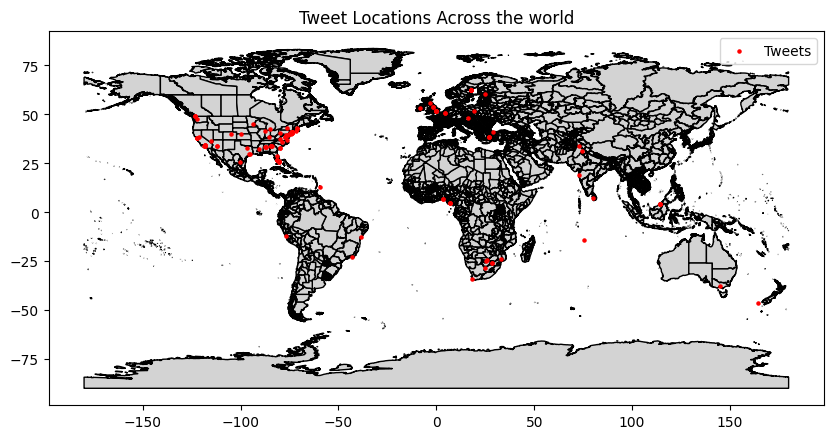

In [90]:
import geopandas as gpd
import ast
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Filter for rows where the 'coordinates' column is not null
tweets_with_coords = interesting_tweets[interesting_tweets["coordinates"].notnull()]

tweets_with_coords['coordinates'] = tweets_with_coords['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Now, apply the function to extract the coordinates as a set
tweets_with_coords['coordinates_set'] = tweets_with_coords['coordinates'].apply(
    lambda x: (x['coordinates'][0], x['coordinates'][1]) if isinstance(x, dict) else None
)
#---

# Check the first few rows to ensure coordinates are correctly extracted
print(tweets_with_coords["coordinates_set"].head())

# Create the GeoDataFrame with geometry (Point objects)
geometry = tweets_with_coords["coordinates_set"].apply(lambda coord: Point(coord[0], coord[1]) if coord else None)
gdf_tweets = gpd.GeoDataFrame(tweets_with_coords, geometry=geometry)

# Check if GeoDataFrame was created successfully
print(gdf_tweets.head())

# Load a basemap of US (using shapefile for US states)
us_states = gpd.read_file("tl_2024_us_state/tl_2024_us_state.shp")
# Load the built-in Natural Earth world map dataset
world = gpd.read_file("ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")

# Plotting the world map
fig, ax = plt.subplots(figsize=(10, 8))
world.plot(ax=ax, color='lightgray', edgecolor='black')
gdf_tweets.plot(ax=ax, color="red", markersize=5, label="Tweets")  # Plot tweets


plt.title("Tweet Locations Across the world")
plt.legend()
plt.show()

# # Plotting the map
# fig, ax = plt.subplots(figsize=(10, 8))
# us_states.plot(ax=ax, color="lightgray", edgecolor="black")  # Plot US states
# gdf_tweets.plot(ax=ax, color="red", markersize=5, label="Tweets")  # Plot tweets

# plt.title("Tweet Locations Across the US")
# plt.legend()
# plt.show()



In [95]:
# Apply keyword-specific sentiment analysis
def analyze_aspects_sentiment_for_map(sentence, aspects, absa_tokenizer, absa_model, sentiment_model):
    sentiment_results = {}

    # Analyze sentiment for each aspect (e.g., food, service)
    for aspect in aspects:
        if aspect.lower() not in sentence.lower():
            print(f"Aspect '{aspect}' not found in the sentence.")
            continue  # Skip sentiment analysis for this aspect
        inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
        outputs = absa_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        probs = probs.detach().numpy()[0]
        
        # Format aspect sentiment result
        sentiment_results[aspect] = {
            "negative": probs[0],
            "neutral": probs[1],
            "positive": probs[2]
        }

        # Print the sentiment of the aspect in the requested format
        #print(f"Sentiment of aspect '{aspect}' is:")
        #for label, prob in sentiment_results[aspect].items():
            #print(f"Label {label}: {prob}")
        #print()

    # Overall sentiment of the sentence
    sentiment = sentiment_model([sentence])[0]
    #print(f"Overall sentiment: {sentiment['label']} with score {sentiment['score']}")

    return sentiment_results




for _, tweet in interesting_tweets_sample.iterrows():  # Use iterrows to loop over rows
    print(f"Tweet: {tweet['cleaned_text']}")
    sentiment_results_tweets = analyze_aspects_sentiment_for_map(
        tweet['cleaned_text'], all_keywords, absa_tokenizer, absa_model, sentiment_model
    )
    print(sentiment_results_tweets)

Tweet: con peras y manzanas: ¿qué proponen clinton y trump sobre méxico?  election2016 
Aspect 'hillary' not found in the sentence.
{'trump': {'negative': np.float32(0.0066327103), 'neutral': np.float32(0.9909338), 'positive': np.float32(0.002433612)}, 'clinton': {'negative': np.float32(0.0056779515), 'neutral': np.float32(0.99195987), 'positive': np.float32(0.002362126)}}
Tweet: if u live in cali and u voted for trump, cali is democrat and u vote went to hillary. congrats
Aspect 'clinton' not found in the sentence.
{'trump': {'negative': np.float32(0.8356063), 'neutral': np.float32(0.15606467), 'positive': np.float32(0.008329095)}, 'hillary': {'negative': np.float32(0.009462958), 'neutral': np.float32(0.012070675), 'positive': np.float32(0.97846633)}}
Tweet: its judgement day usa. as much as my contempt for trump is apparent everyone gets their vote. so use it vote election2016
Aspect 'hillary' not found in the sentence.
Aspect 'clinton' not found in the sentence.
{'trump': {'negative

# Manuellt skapa ett dataset att jämföra med

Manuellt fixa en databas med x antal tweets och sätta trump sentiment och hillary sentiment som antingen positive, negative, eller neutral. Detta för att ha något att jämföra med.